## Stimuli Project PSD

In [9]:
import os
import mne
import numpy as np
from typing import Dict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


from NirsLabProject.config.paths import Paths
from NirsLabProject.config.consts import *
from NirsLabProject.config.subject import Subject
from NirsLabProject.utils import pipeline_utils
from NirsLabProject.utils import general_utils as utils



In [2]:
subject = Subject('p485', True)
raw = pipeline_utils.resample_and_filter_data(subject)

Reading raw data...
Data for electrode LMH was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['LMH1', 'LMH2', 'LMH3', 'LMH4', 'LMH5', 'LMH6', 'LMH7'] channels, 1000.0 Hz
Data for electrode LOF was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['LOF1', 'LOF2', 'LOF3', 'LOF4', 'LOF5', 'LOF6', 'LOF7'] channels, 1000.0 Hz
Data for electrode RBAA was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['RBAA1', 'RBAA2', 'RBAA3', 'RBAA4', 'RBAA5', 'RBAA6', 'RBAA7'] channels, 1000.0 Hz
Data for electrode ROF was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['ROF1', 'ROF2', 'ROF3', 'ROF4', 'ROF5', 'ROF6', 'ROF7'] channels, 1000.0 Hz
Data for electrode RPHG was already resampled, reading it...
Cleaning channels names
Raw data shape: 37152.999 seconds, ['RPHG1', 'RPHG2', 'RPHG3', 'RPHG4', 'RPHG5', 'RPHG6', 'RPHG7'] chan

In [8]:
def get_model_name(subject: Subject) -> str:
    return f"{'bipolar' if subject.bipolar_model else 'one channel'} model"

def create_psd_of_stimuli_and_pause_blocks(
        subject: Subject, flat_features: np.ndarray, raw: mne.io.Raw, channel_name: str,
        name_to_index: Dict[str, int], show: bool = False):
        channel_index = name_to_index.get(channel_name, None)
        if channel_index is None:
            print(f'Channel {channel_name} not found')
            return 0
        
        only_stimuli_block_indexes = np.logical_and(
            flat_features[:, CHANNEL_INDEX] == channel_index,
            flat_features[:, STIMULI_FLAG_INDEX] == STIMULI_FLAG_DURING_STIMULI_BLOCK
        )
        
        without_stimuli_blocks_indexes = np.logical_and(
            flat_features[:, CHANNEL_INDEX] == channel_index,
            flat_features[:, STIMULI_FLAG_INDEX] != STIMULI_FLAG_DURING_STIMULI_BLOCK,
        )
                
        channel_raw = raw.copy().pick_channels([channel_name])
        channel_raw.load_data()
        only_stimuli_block_times = flat_features[only_stimuli_block_indexes][:, TIMESTAMP_INDEX]
        only_stimuli_block_times = only_stimuli_block_times.reshape(-1, 1).astype(int)
        stimuli_epochs = utils.create_epochs(channel_raw, only_stimuli_block_times, -1, 1)
        
        without_stimuli_blocks_times = flat_features[without_stimuli_blocks_indexes][:, TIMESTAMP_INDEX]
        without_stimuli_blocks_times = without_stimuli_blocks_times.reshape(-1, 1).astype(int)
        no_stimuli_epochs = utils.create_epochs(channel_raw, without_stimuli_blocks_times, -1, 1)
        
        
        psd = lambda x: 10*np.log10(x.average().get_data()*10**12)
        stimuli_epochs_psd = psd(stimuli_epochs.compute_psd(fmin=0,fmax=250))
        no_stimuli_epochs_psd = psd(no_stimuli_epochs.compute_psd(fmin=0,fmax=250))
        if no_stimuli_epochs_psd.shape[1] < 20 or stimuli_epochs_psd.shape[1] < 20:
            print(f'Skipping channel {channel_name}')
            return 0

        return (no_stimuli_epochs_psd-stimuli_epochs_psd).sum()

    
avgs = []
# for p in ['p485', 'p486', 'p488', 'p496', 'p499', 'p520']:
for p in ['p496']:
    subject = Subject(p, True)
    features = np.load(subject.paths.subject_flat_features_path, allow_pickle=True)
    index_to_name = np.load(subject.paths.subject_channel_name_to_index_path, allow_pickle=True).item()
    name_to_index = {name: index for index, name in index_to_name.items()}
    raw = pipeline_utils.resample_and_filter_data(subject)
    s = 0
    c = 0
    for _, channels in raw.items():
        for ch_name in channels.ch_names:
            try:
                av = create_psd_of_stimuli_and_pause_blocks(subject, features, channels, ch_name, name_to_index, True)
            except Exception as e:
                continue
            if av:
                s += av
                c += 1
    print(f'{p}: {s/c}')
    avgs.append(s/c)
print(avgs)

Reading raw data...
Data for electrode RIOp was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RIOp1', 'RIOp2', 'RIOp3', 'RIOp4', 'RIOp5', 'RIOp6', 'RIOp7'] channels, 1000.0 Hz
Data for electrode RTp was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RTp1', 'RTp2', 'RTp3', 'RTp4', 'RTp5', 'RTp6', 'RTp7'] channels, 1000.0 Hz
Data for electrode RTOP was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RTOP1', 'RTOP2', 'RTOP3', 'RTOP4', 'RTOP5', 'RTOP6', 'RTOP7', 'RTOP8'] channels, 1000.0 Hz
Data for electrode RPO was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RPO1', 'RPO2', 'RPO3', 'RPO4', 'RPO5', 'RPO6', 'RPO7'] channels, 1000.0 Hz
Data for electrode RIO was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RIO1', 'RIO2', 'RIO3', 'RIO4', 'RIO5', 'RIO6', 'RI

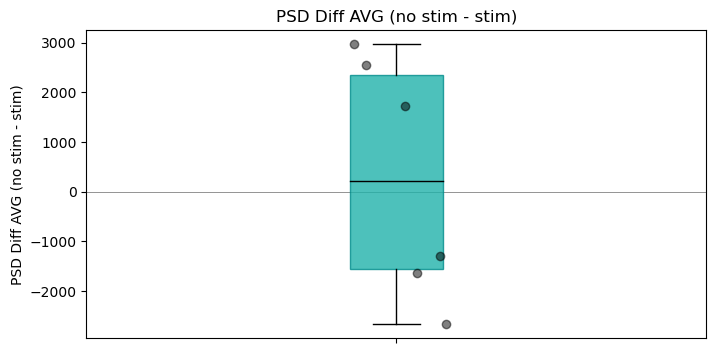

In [5]:
from NirsLabProject.utils import plotting
avgs = [2973.0842268657666, 2552.4710171671186, 1721.511032050522, -1635.945029703765, -2670.460604105578, -1303.3754536791464]
plotting.create_box_plot_for_stimuli(
    "/tmp",
    [len(avgs)],
    {
        "": {
           "PSD Diff AVG (no stim - stim)": avgs
        }
        
    },
    "PSD Diff AVG (no stim - stim)"
)

In [12]:
subject = Subject('p496', True)
raw = pipeline_utils.resample_and_filter_data(subject)

Reading raw data...
Data for electrode RIOp was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RIOp1', 'RIOp2', 'RIOp3', 'RIOp4', 'RIOp5', 'RIOp6', 'RIOp7'] channels, 1000.0 Hz
Data for electrode RTp was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RTp1', 'RTp2', 'RTp3', 'RTp4', 'RTp5', 'RTp6', 'RTp7'] channels, 1000.0 Hz
Data for electrode RTOP was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RTOP1', 'RTOP2', 'RTOP3', 'RTOP4', 'RTOP5', 'RTOP6', 'RTOP7', 'RTOP8'] channels, 1000.0 Hz
Data for electrode RPO was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RPO1', 'RPO2', 'RPO3', 'RPO4', 'RPO5', 'RPO6', 'RPO7'] channels, 1000.0 Hz
Data for electrode RIO was already resampled, reading it...
Cleaning channels names
Raw data shape: 29885.999 seconds, ['RIO1', 'RIO2', 'RIO3', 'RIO4', 'RIO5', 'RIO6', 'RI

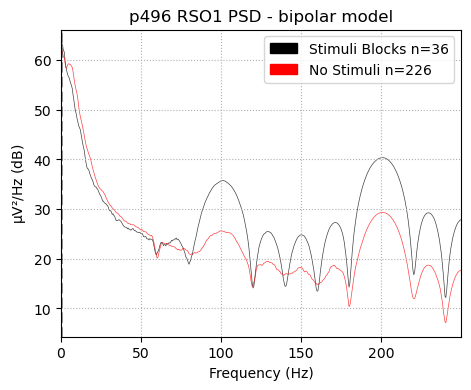

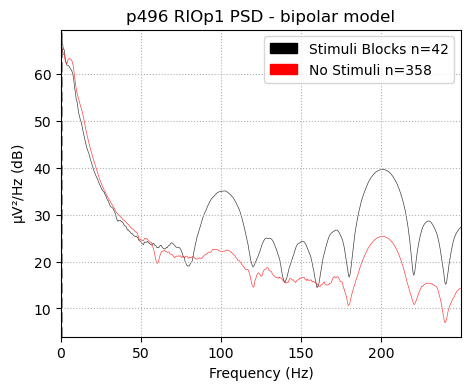

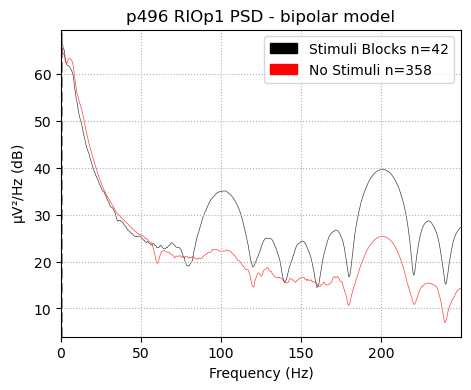

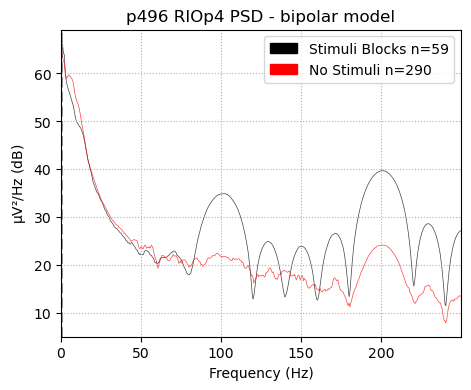

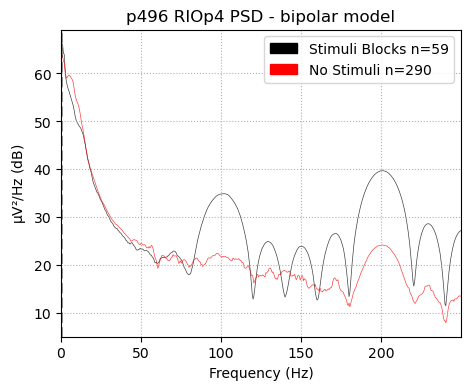

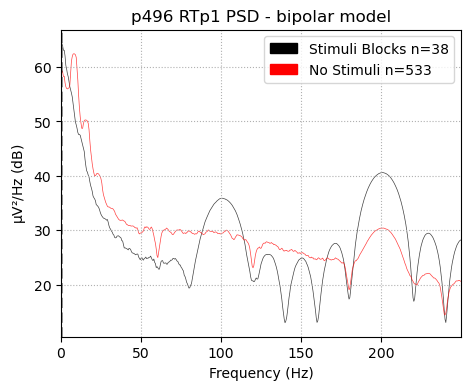

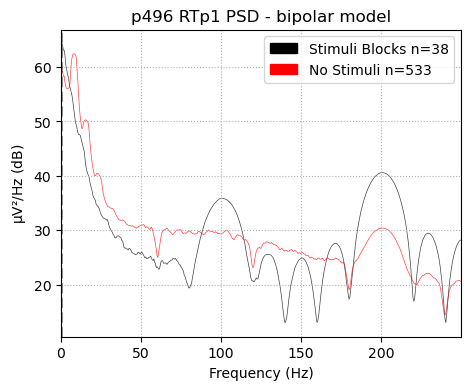

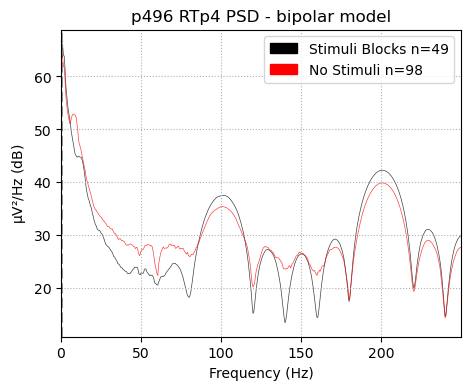

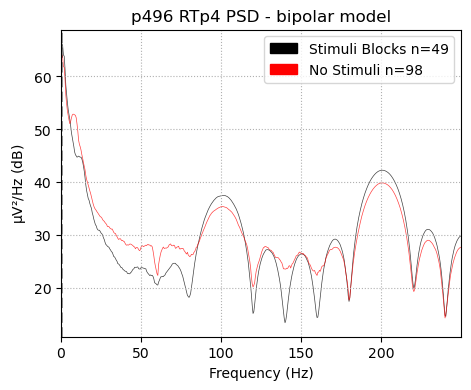

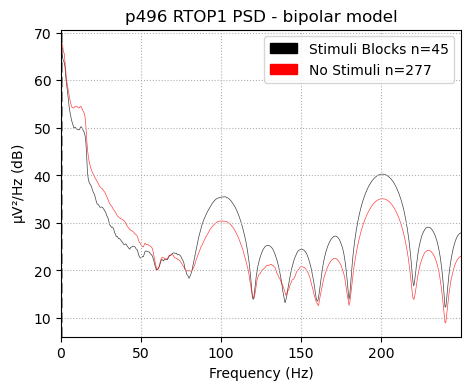

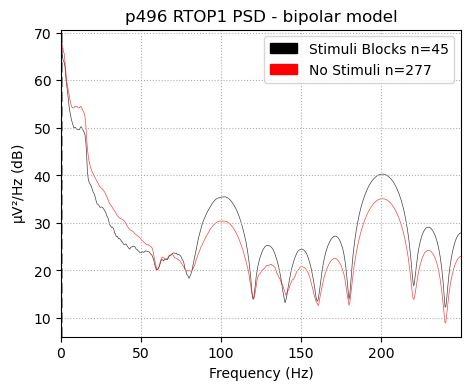

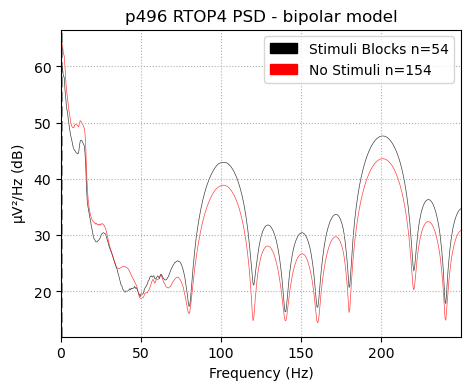

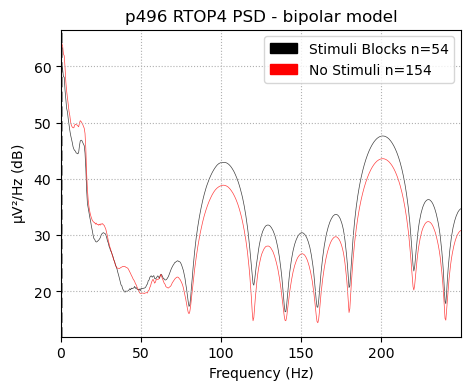

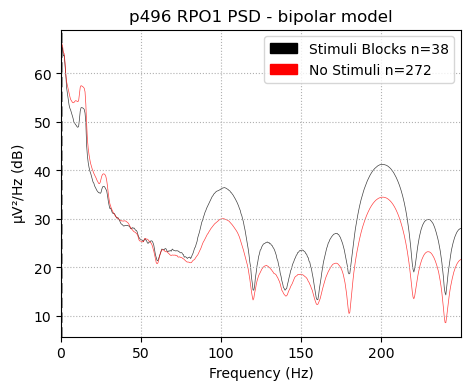

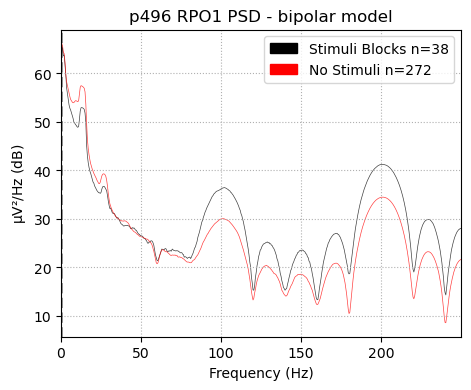

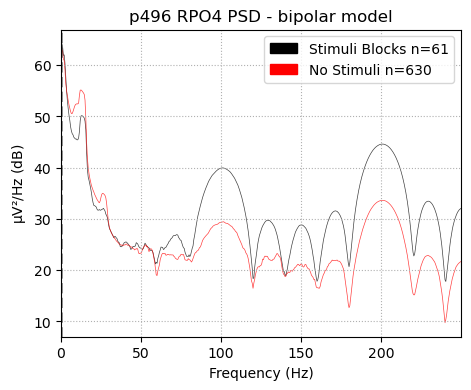

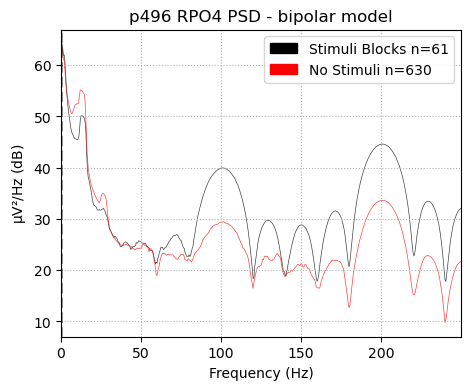

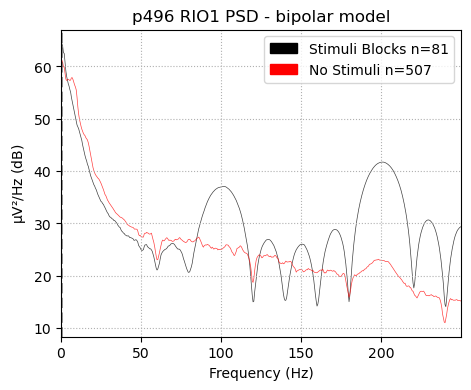

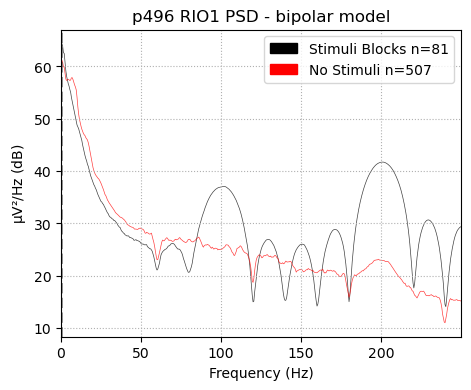

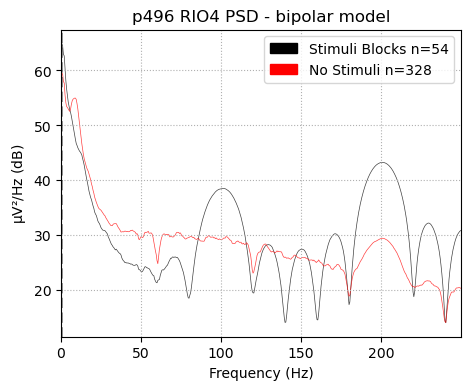

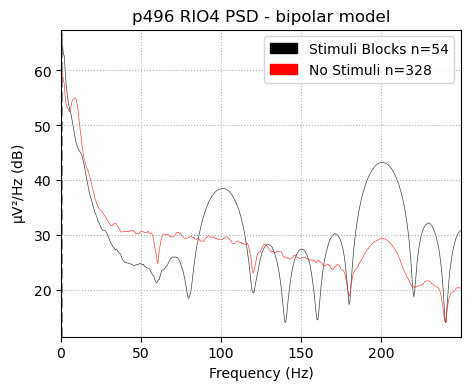

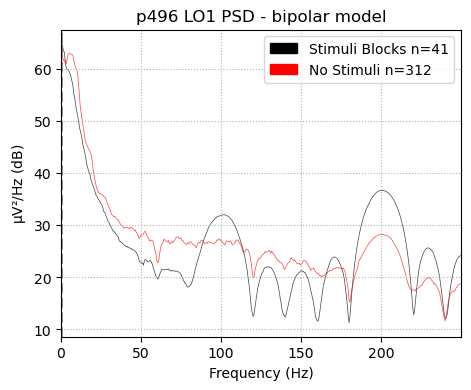

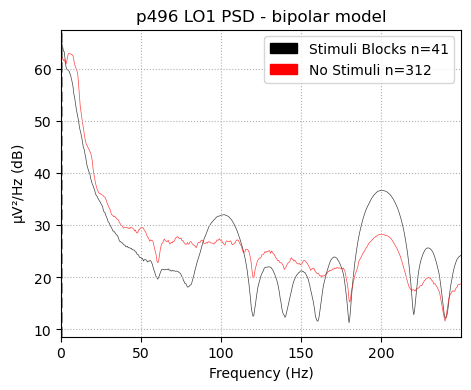

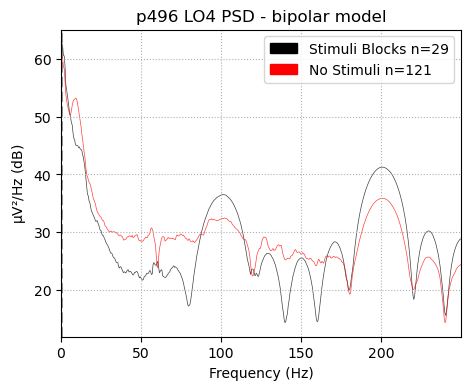

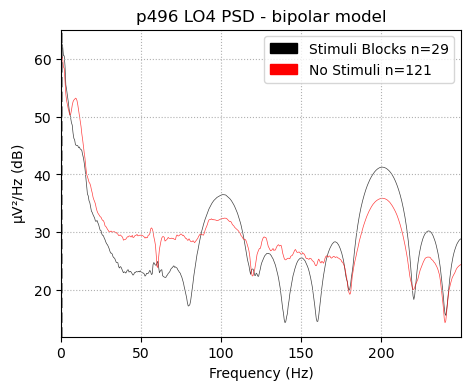

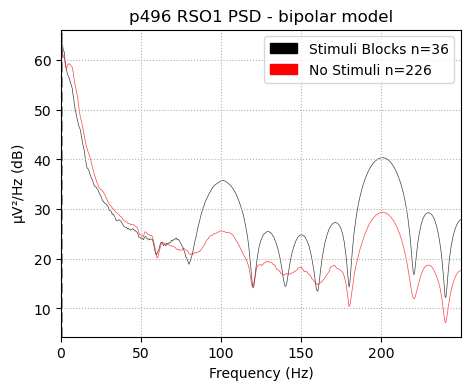

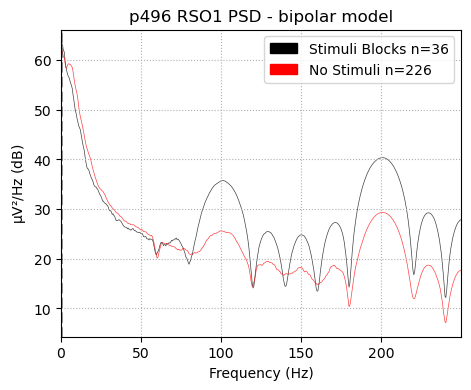

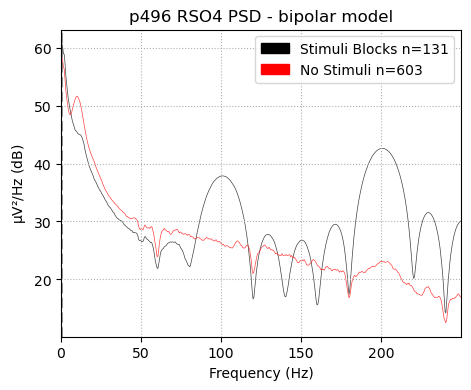

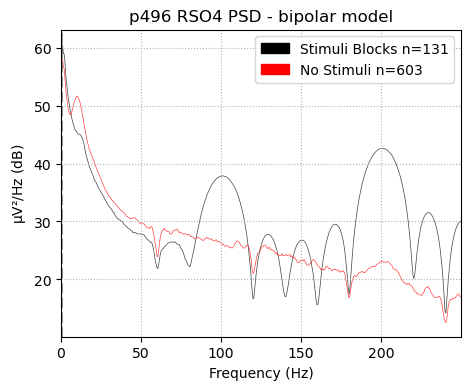

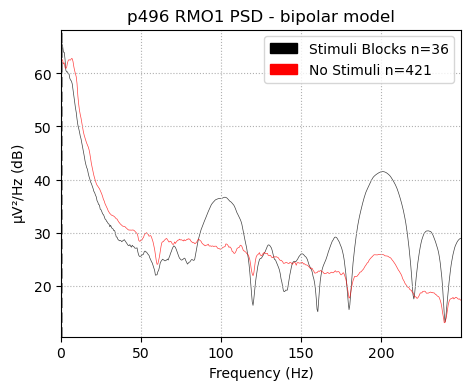

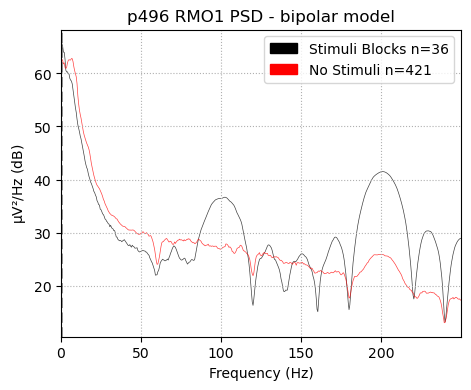

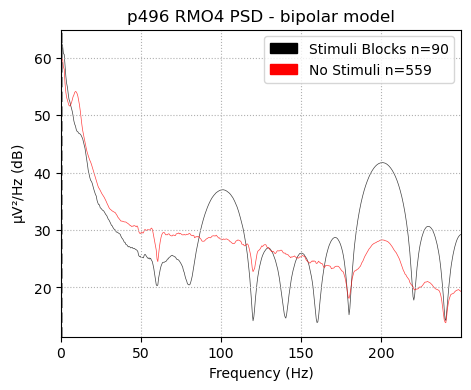

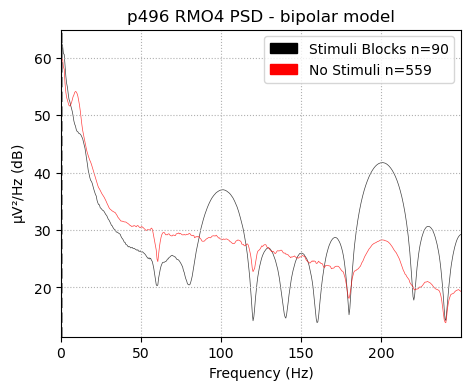

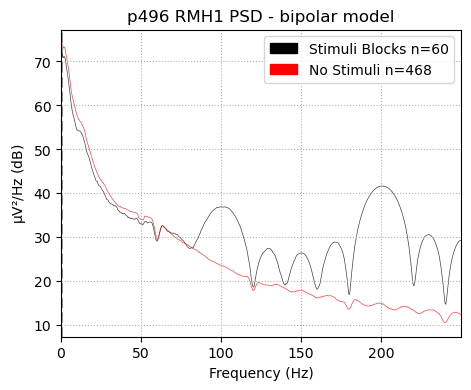

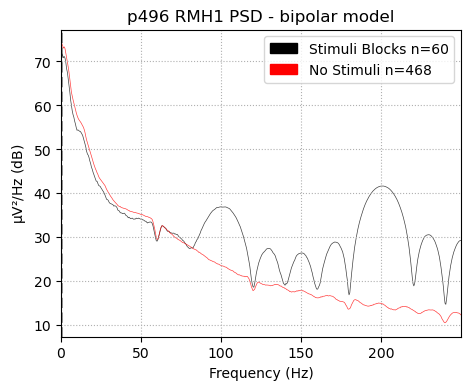

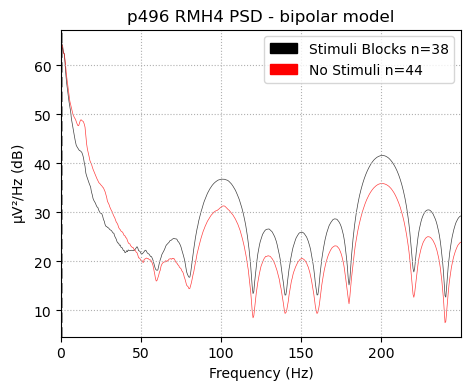

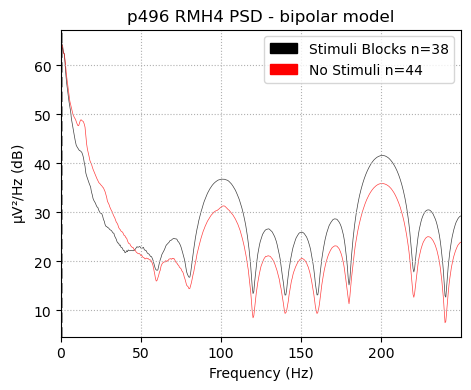

In [67]:
def create_psd_of_stimuli_and_no_stimuli_blocks(
        subject: Subject, flat_features: np.ndarray, raw: mne.io.Raw, channel_name: str,
        name_to_index: Dict[str, int], show: bool = False, notch = True):
    channel_index = name_to_index.get(channel_name, None)
    if channel_index is None:
        print(f'Channel {channel_name} not found')
        return

    only_stimuli_block_indexes = np.logical_and(
        flat_features[:, CHANNEL_INDEX] == channel_index,
        flat_features[:, STIMULI_FLAG_INDEX] == STIMULI_FLAG_DURING_STIMULI_BLOCK
    )

    without_stimuli_blocks_indexes = np.logical_and(
        flat_features[:, CHANNEL_INDEX] == channel_index,
        flat_features[:, STIMULI_FLAG_INDEX] != STIMULI_FLAG_DURING_STIMULI_BLOCK,
    )

    channel_raw = raw.copy().pick_channels([channel_name])
    channel_raw.load_data()
    if notch:
        channel_raw = channel_raw.notch_filter(50)
    only_stimuli_block_times = flat_features[only_stimuli_block_indexes][:, TIMESTAMP_INDEX]
    only_stimuli_block_times = only_stimuli_block_times.reshape(-1, 1).astype(int)
    stimuli_epochs = utils.create_epochs(channel_raw, only_stimuli_block_times, -1, 1)

    without_stimuli_blocks_times = flat_features[without_stimuli_blocks_indexes][:, TIMESTAMP_INDEX]
    without_stimuli_blocks_times = without_stimuli_blocks_times.reshape(-1, 1).astype(int)
    no_stimuli_epochs = utils.create_epochs(channel_raw, without_stimuli_blocks_times, -1, 1)

    fig = plt.figure(layout='constrained')
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    # plot_psd is obsolete, but the new function plot_psd_topomap is not supporting fig saving
    stimuli_epochs.plot_psd(
        fmin=0,
        fmax=250,
        picks=[channel_name],
        ax=ax,
        show=show,
        spatial_colors=False
    )

    no_stimuli_epochs.plot_psd(
        fmin=0,
        fmax=250,
        ax=ax,
        show=show,
        spatial_colors=False,
        color='red'
    )
    ax.set_title(f'{subject.name} {channel_name} PSD - {get_model_name(subject)}')
    ax.set_xlabel('Frequency (Hz)')
    legend = [
        mpatches.Patch(color='black', label=f'Stimuli Blocks n={only_stimuli_block_times.shape[0]}'),
        mpatches.Patch(color='red', label=f'No Stimuli n={without_stimuli_blocks_times.shape[0]}')
    ]
    ax.legend(handles=legend, bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(subject.paths.subject_psd_plots_dir_path,
                             f'{subject.name}-{channel_name}-stimuli-blocks-vs-non.png'), dpi=1000)
    if show:
        plt.show()

features = np.load(subject.paths.subject_flat_features_path, allow_pickle=True)
index_to_name = np.load(subject.paths.subject_channel_name_to_index_path, allow_pickle=True).item()
name_to_index = {name: index for index, name in index_to_name.items()}

for _, channels in raw.items():
    for ch_name in channels.ch_names:
        if ch_name.endswith('1') or ch_name.endswith('4'):
            create_psd_of_stimuli_and_no_stimuli_blocks(subject, features, channels, ch_name, name_to_index, True, True)
            create_psd_of_stimuli_and_no_stimuli_blocks(subject, features, channels, ch_name, name_to_index, True, False)
